# **Problema 1 - Aprendizaje Automático II**
# *Integrantes*:
* ### Demarré, Lucas
* ### Donnarumma, César
* ### Longo, Bruno

---

# **Tabla de contenidos**

1.   [**Librerías**](#)
2.   [**Establecemos una seed para reproducibilidad**](#)
3.   [**Establecemos la GPU por defecto en caso de estar disponible**](#)
4.   [**Carga y mostramos información del Dataset**](#)
        1.   [*Cargamos el Dataset*](#)
        2.   [*Información del Dataset*](#)
        3.   [*Comprobación de cantidad de elementos descargados*](#)
        4.   [*Comprobación de las longitudes del Dataset*](#)
5.   [**Primer etapa de Pre-procesamiento**](#)
        1.   [*Agregamos padding a la longitud del audio, truncamiento y normalización entre -1 y 1*](#)
        2.   [*Información del Dataset*](#)
6.   [**Batching y División train-test**](#)
7.   [**Segunda etapa de Pre-procesamiento**](#)
        1.   [*Volvemos a inspeccionar la estructura del Dataset*](#)
        2.   [*Ploteamos la forma de onda para algunos ejemplos*](#)
        3.   [*Verificación del balanceo de las clases en el Dataset de entrenamiento*](#)
        4.   [*Conversión de formas de onda a espectrogramas*](#)
        5.   [*Mostramos algunos ejemplos con label, forma en dominio del tiempo (wave) y en el dominio del tiempo-frecuencia (espectrograma) y reproducimos el audio correspondiente*](#)
        6.   [*Función para mostrar el espectrograma*](#)
        7.   [*Gráfico de onda / espectograma para un audio*](#)
        8.   [*Dataset de espectrogramas*](#)
        9.   [*Examinamos el espectrograma para distintos ejemplos del dataset y graficamos 9 de ellos*](#)
8.   [**Modelo con Redes Neuronales Convolucionales**](#)
        1.   [*Optimizamos la carga del Dataset*](#)
        2.   [*Contruimos el modelo*](#)
        3.   [*Compilamos el modelo*](#)
        4.   [*Entrenamos el modelo*](#)
        5.   [*Mostramos los resultados*](#)
        6.   [*Métricas*](#)
             1.   [**Cálculo de predicciones en test**](#)
             2.   [**Matriz de confusión**](#)
             3.   [**Informe de clasificación**](#)
9.   [**Modelo con Redes Neuronales Recurrentes**](#)
        1.   [*Pre-procesamiento*](#)
        2.   [*Optimizamos la carga del Dataset*](#)
        3.   [*Construimos el  modelo*](#)
        4.   [*Compilamos el modelo*](#)
        5.   [*Entrenamos el modelo*](#)
        6.   [*Mostramos los resultados*](#)
        7.   [*Métricas*](#)
             1.   [**Cálculo de predicciones en test**](#)
             2.   [**Matriz de confusión**](#)
             3.   [**Informe de clasificación**](#)
10.   [**Conclusiones**](#)

## 1. **Librerías**

In [ ]:
import os
import time
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.metrics import classification_report
#!pip install pydub # Lo pide tfds.load() cuando intentamos descargar de dataset

## 2. **Establecemos una seed para reproducibilidad**

In [ ]:
# Para obtener siempre el mismo resultado. Cualquier operación "random" se fija el seed y resulta siempre en lo mismo
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## 3. **Establecemos la GPU por defecto en caso de estar disponible**

In [ ]:
# Configuramos para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configuramos para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Especificamos la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e) # Manejamos los errores

1 Physical GPUs, 1 Logical GPUs


## 4. **Carga y mostramos información del Dataset**

### 4.1. *Cargamos el Dataset*

In [ ]:
ds_digit, ds_digit_info = tfds.load('spoken_digit', split='train', shuffle_files=True, as_supervised=True, with_info=True)
assert isinstance(ds_digit, tf.data.Dataset) # Comprobación de que "ds_digit" sea instancia de "tf.data.Dataset"

### 4.2. *Información del Dataset*

In [ ]:
print(ds_digit_info,'\n''\n',ds_digit.element_spec)

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
    
    5 speakers
    2,500 recordings (50 of each digit per speaker)
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='C:\\Users\\lucas\\tensorflow_datasets\\spoken_digit\\1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_c

* Longitud de secuencia variable *(shape=(None,))* en datos de entrada
* Labels corresponde a un escalar *(shape=())*
* Hay que rellenar con *padding = 0* hasta **8000** samples y truncar las que sean mayores (si es que hay)

### 4.3. *Comprobacion de cantidad de elementos descargados*

In [ ]:
cantidad_datos = ds_digit_info.splits['train'].num_examples
print(f'Cantidad total de datos: {cantidad_datos}')

Cantidad total de datos: 2500


### 4.4. *Comprobación de las longitudes del Dataset*

In [ ]:
# Función para obtener la longitud de cada audio
def longitudes_audios(audio, label):
    return tf.shape(audio)[0]

# Aplicamos la función al Dataset para obtener las longitudes
ds_digit_longitudes = ds_digit.map(longitudes_audios)

longitudes = []

# Obtenemos todas las longitudes
for longitud_audio in ds_digit_longitudes:
    longitudes.append(int(longitud_audio.numpy()))

# Buscamos las longitudes mayores a 8000
longitud = pd.DataFrame(longitudes, columns=['longitud'])
longitud[longitud['longitud'] > 8000]

,longitud
1694,8281
1877,8201
2019,18262
2101,17567


* Hay cuatro elementos con longitudes mayores a 8000 que debemos truncar

## 5. **Primer etapa de Pre-procesamiento**

### 5.1. *Agregamos padding a la longitud del audio, truncamiento y normalización entre -1 y 1*

In [ ]:
# Longitud deseada de samples para cada audio
long_deseada = 8000

# Función para normalizar el audio entre -1 y 1
def normalizar_audio(audio):
    audio = tf.cast(audio, tf.float32) # Casteo de tipo de dato
    max_val = tf.reduce_max(tf.abs(audio)) # Encontramos el máximo valor absoluto dentro del tensor
    audio = audio / max_val # Dividimos cada valor entre el máximo valor absoluto para que queden entre -1 y 1
    return audio

# Función para cargar y preprocesar un audio
def preprocesar_audio(audio, label):

    # Longitud del audio
    audio_length = tf.shape(audio)[0]

    # Si es menor que la longitud deseada
    if audio_length < long_deseada:
        # Agregamos el padding
        paddings = [[0, long_deseada - audio_length]]
        audio = tf.pad(audio, paddings=paddings)
    # Caso contrario
    else:
        # Truncamos la longitud hasta la longitud deseada
        audio = audio[:long_deseada]


    audio = tf.ensure_shape(audio, [long_deseada]) # Longitud ya no es fija sino de 8000
    audio = normalizar_audio(audio) # Normalizamos el audio entre -1 y 1

    return audio, label

# Aplicamos la función de carga y preprocesamiento al Dataset
ds_digit = ds_digit.map(preprocesar_audio)

### 5.2. *Volvemos a inspeccionar los elementos del Dataset*

In [ ]:
ds_digit.element_spec

(TensorSpec(shape=(8000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

* Ahora la longitud de secuencia es fija (8000, antes era None)

## 6. **Batching y División train-test**

In [ ]:
batch_size = 64
train_test_split = 0.8  # 80% para entrenamiento y 20% para prueba

# Dividir el dataset en entrenamiento y prueba
ds_digit_train = ds_digit.take(int(train_test_split * cantidad_datos))
ds_digit_test = ds_digit.skip(int(train_test_split * cantidad_datos))

# Agrupar los datos en lotes
ds_digit_train = ds_digit_train.batch(batch_size)
ds_digit_test = ds_digit_test.batch(batch_size)

# Prefetch para mejorar el rendimiento
ds_digit_train = ds_digit_train.prefetch(tf.data.AUTOTUNE)
ds_digit_test = ds_digit_test.prefetch(tf.data.AUTOTUNE)

* El shuffle se hizo cuando se cargo el dataset en la linea de carga.

## 7. **Segunda etapa de Pre-procesamiento**

### 7.1. *Volvemos a inspeccionar la estructura del Dataset*

In [ ]:
# Verificamos la estructura del dataset
print(ds_digit_train.element_spec) # El tamaño de batch aparece como variable porque puede ser que el último batch tenga menos elementos

# Mirando el primero se nota que el tamaño esta fijo
for example_audio, example_labels in ds_digit_train.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(TensorSpec(shape=(None, 8000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(64, 8000)
(64,)


* Ahora tenemos una nueva primera dimensión en la forma *(None)* que corresponde a la longitud de batch variable, por más que pusimos 64 algún batch quedó más chico

### 7.2. *Ploteamos la forma de onda para algunos ejemplos*

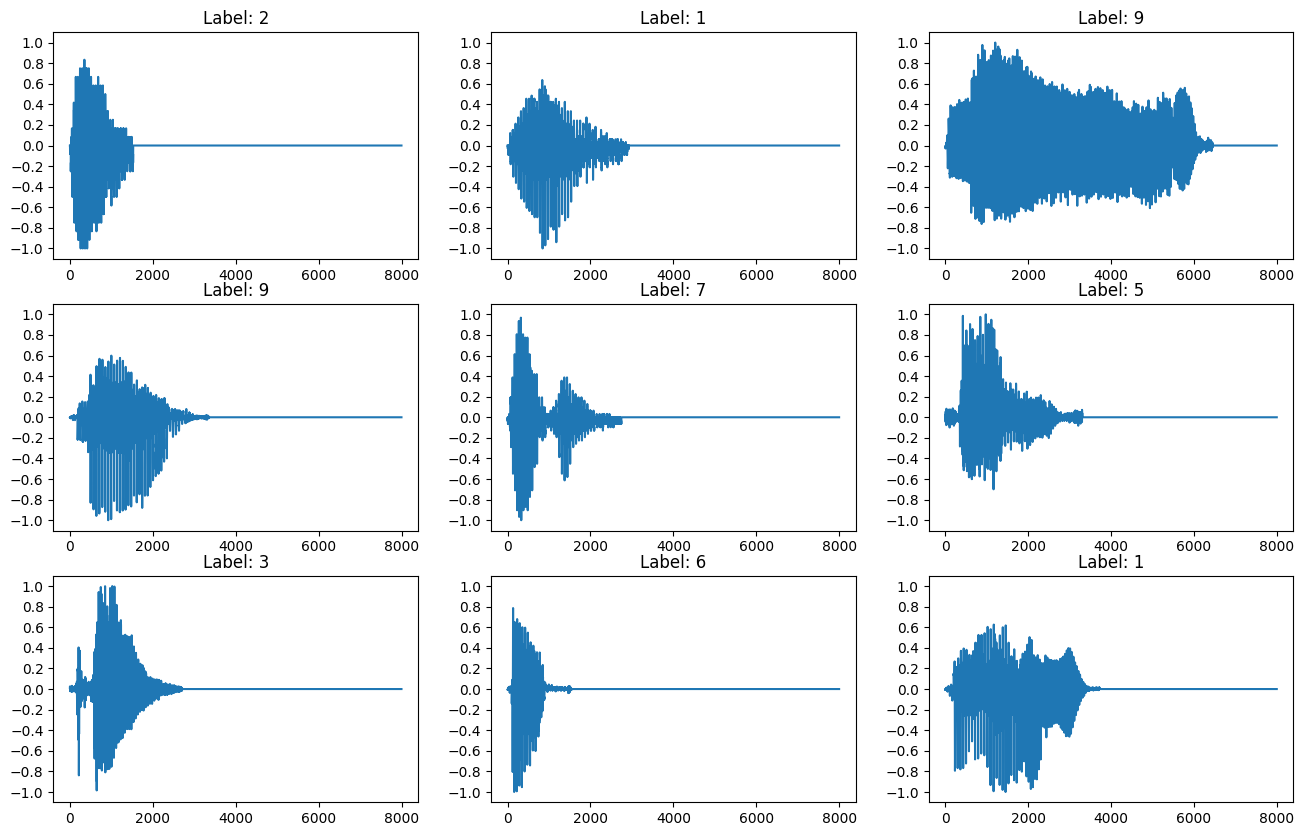

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(f"Label: {str(example_labels[i].numpy())}")
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

### 7.3. *Verificación del balanceo de las clases en el Dataset de entrenamiento*

In [ ]:
lista_labels = []

# Obtenemos todas las longitudes
for _, labels in ds_digit_train:
    lista_labels.append(labels.numpy())
lista_labels = np.concatenate(lista_labels)

# Buscamos las longitudes mayores a 8000
df_labels = pd.DataFrame(lista_labels, columns=['labels'])
df_labels.value_counts()

labels
2         208
7         204
0         203
5         203
4         202
9         200
3         198
1         196
6         194
8         192
Name: count, dtype: int64

* El dataset esta bastante balanceado

### 7.4. *Conversión de formas de onda a espectrogramas*

In [ ]:
def get_spectrogram(waveform):
  # Convertimos de "wave" a "espectrograma" con STFT.
  espectrograma = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # Con esto definimos cuanta información quiero perder cuando se haga STFT

  # Obtenemos la magnitud del STFT
  espectrograma = tf.abs(espectrograma) # Nos quedamos solo con la amplitud haciendo el valor absoluto

  espectrograma = espectrograma[..., tf.newaxis]
  return espectrograma

* Con la función de arriba pasamos de *wave* a *espectrograma* (dominio del tiempo a dominio tiempo-frecuencia)

### 7.5. *Mostramos algunos ejemplos con label, forma en dominio del tiempo (wave) y en el dominio del tiempo-frecuencia (espectrograma) y reproducimos el audio correspondiente*

In [ ]:
for i in range(3):
  label = example_labels[i]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label) # Etiqueta
  print('Waveform shape:', waveform.shape) # Forma del audio en el dominio del tiempo, tiene que ser (8000, 0)
  print('Spectrogram shape:', spectrogram.shape) # Forma del audio en el dominio del tiempo-frecuencia
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))
  # El rate y la frecuencia de sampleo son las mismas que el Dataset original utiliza

Label: tf.Tensor(2, shape=(), dtype=int64)
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: tf.Tensor(1, shape=(), dtype=int64)
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: tf.Tensor(9, shape=(), dtype=int64)
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


* Vemos como la forma del waveform es *(8000,)* que corresponde a **8000** muestras con valores de amplitud correspondientes
* La forma del espectrograma es *(61, 129, 1)*, que tenga esta pinta con 3 ejes nos permite tratarlo como a una imagen

### 7.6 *Función para mostrar el espectrograma*

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, width, num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### 7.7. *Gráfico de onda / espectograma para un audio*

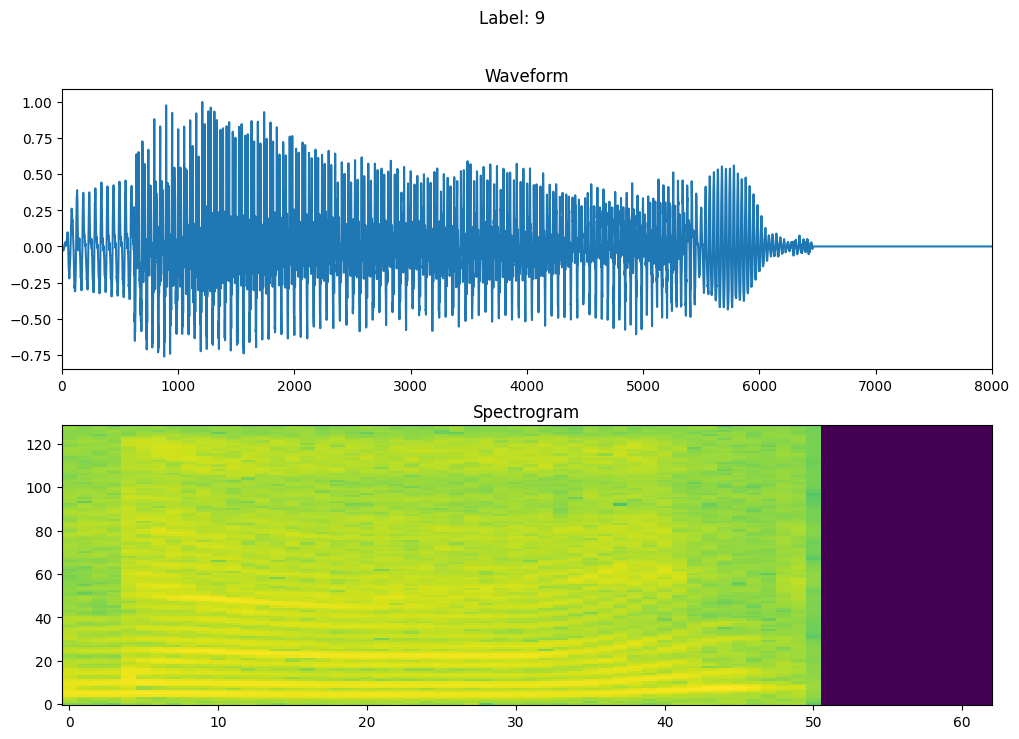

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(f'Label: {str(label.numpy())}')
plt.show()

### 7.8. *Dataset de espectrogramas*

In [ ]:
def crear_ds_espectrograma(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label), # Aplicamos la función definida en el punto 7.4.
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = crear_ds_espectrograma(ds_digit_train)
test_spectrogram_ds = crear_ds_espectrograma(ds_digit_test)

### 7.9 *Examinamos el espectrograma para distintos ejemplos del dataset y graficamos 9 de ellos*

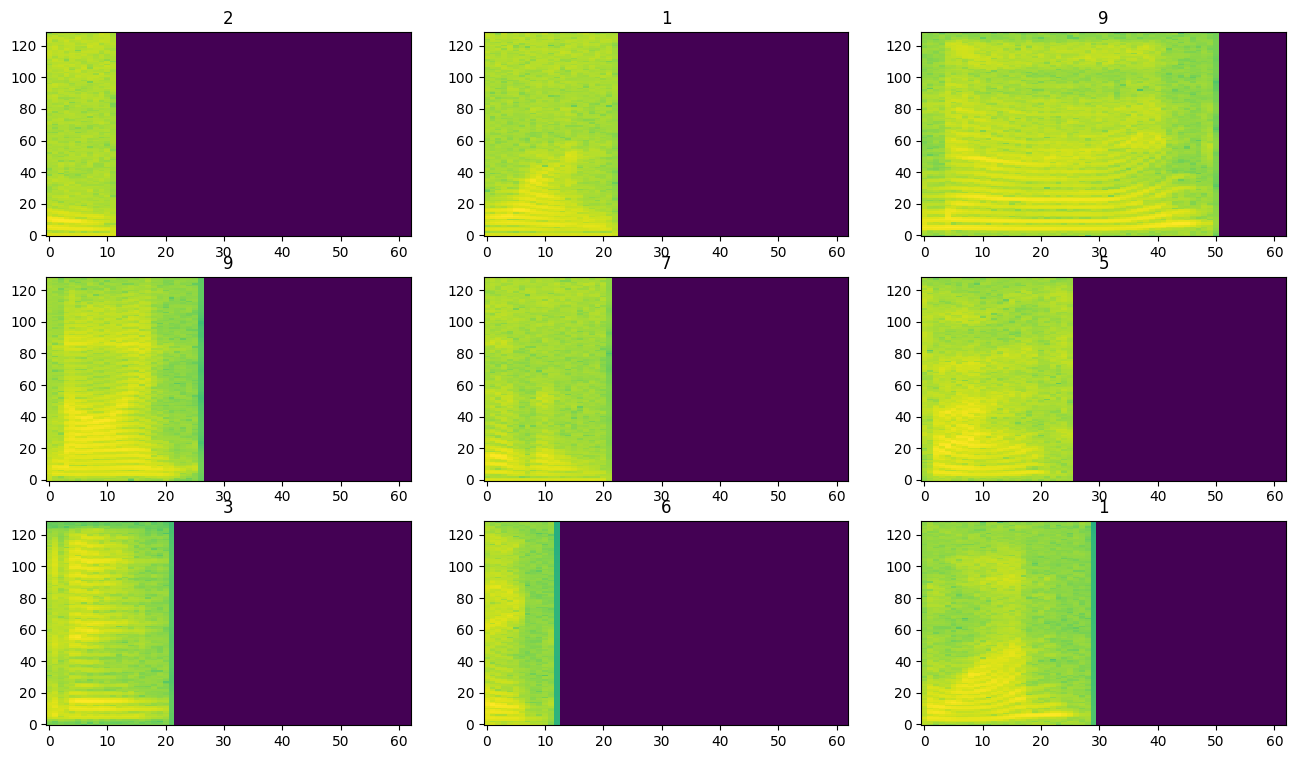

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1): # Del primer batch
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(example_spect_labels[i].numpy())

plt.show()

## 8. **Modelo con Redes Neuronales Convolucionales**

### 8.1. *Optimizamos la carga del Dataset*

In [ ]:
# Mezclamos las instancias de entrenamiento, y las precargamos
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = 10
print('\nNumero de etiquetas:', num_labels)

Input shape: (61, 129, 1)

Numero de etiquetas: 10


### 8.2. *Contruimos el modelo*

In [ ]:
# Instanciamos la capa de normalización
norm_layer = layers.Normalization()

# Le pasamos el Dataset con función 'adapt', para que calcule el 'mean' y el 'sd' para luego utilizarlos para normalizar
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec)) # Nos quedamos con un Dataset que conste solo de espectrogramas para que calcule

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # Hacemos resize de 'imagen' de espectrograma
    norm_layer, # Normalizamos los datos reescalados

    # Convoluciones y Maxpooling
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

### 8.3. *Compilamos el modelo*

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### 8.4. *Entrenamos el modelo*

In [ ]:
EPOCHS = 50

start = time.time()
history = model.fit(
    train_spectrogram_ds,
    validation_data=test_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
end = time.time()
total_time_test1 = round((end-start)/60, 2)

print(f'--------------------------------------')
print(f'Tiempo de ejecucion: {total_time_test1} minutos')
print(f'--------------------------------------')

Epoch 1/50
32/32 [==============================] - 6s 35ms/step - loss: 1.5301 - accuracy: 0.4665 - val_loss: 0.8874 - val_accuracy: 0.7100
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.8055 - accuracy: 0.7250 - val_loss: 0.5721 - val_accuracy: 0.8220
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.5690 - accuracy: 0.8130 - val_loss: 0.4116 - val_accuracy: 0.8660
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.4394 - accuracy: 0.8450 - val_loss: 0.3340 - val_accuracy: 0.9060
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.3203 - accuracy: 0.8985 - val_loss: 0.2991 - val_accuracy: 0.9100
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.2363 - accuracy: 0.9275 - val_loss: 0.2251 - val_accuracy: 0.9300
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.1774 - accuracy: 0.9395 - val_loss: 0.1715 - val_accuracy: 0.9380
Epoch 8/50
32/32 [=

### 8.5. *Mostramos los resultados*

Text(0, 0.5, 'Accuracy [%]')

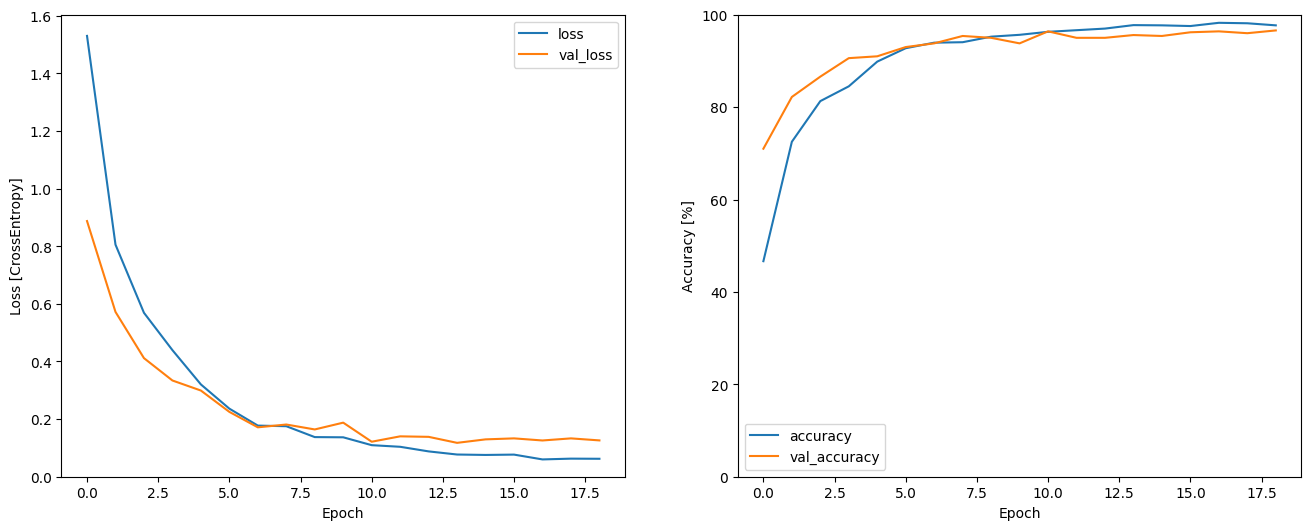

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

* Por las métricas, el modelo funciona muy bien
* El overfitting es insignificante

### 8.6. *Métricas*

#### 8.6.1. **Cálculo de predicciones en test**

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred[0]

8/8 [==============================] - 0s 2ms/step


array([  0.69067866,  -6.121404  ,  -3.9802756 ,  -3.148092  ,
         0.04545552,  -9.196484  ,  12.291042  ,   4.9191813 ,
        -0.72638434, -11.527721  ], dtype=float32)

* Por cada predicción obtenemos los *logits* (si tuviera la softmax seria una distribución de probabilidad)
* El índice del valor más alto corresponde a la clase predicha

#### 8.6.2. **Matriz de confusión**

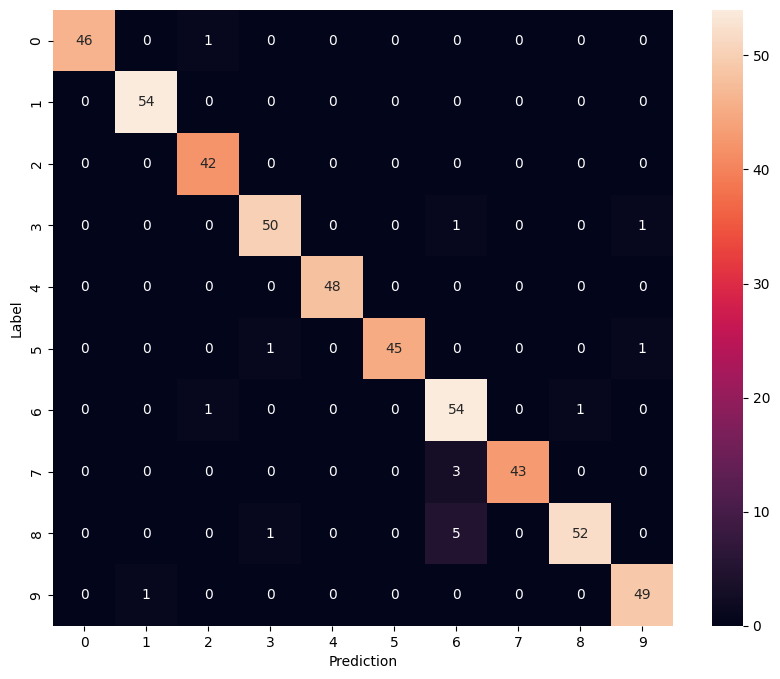

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=range(0,10),
            yticklabels=range(0,10),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### 8.6.3. **Informe de clasificación**

In [ ]:
report = classification_report(y_true.numpy(), y_pred.numpy(), target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.98      1.00      0.99        54
           2       0.95      1.00      0.98        42
           3       0.96      0.96      0.96        52
           4       1.00      1.00      1.00        48
           5       1.00      0.96      0.98        47
           6       0.86      0.96      0.91        56
           7       1.00      0.93      0.97        46
           8       0.98      0.90      0.94        58
           9       0.96      0.98      0.97        50

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## 9. **Modelo con Redes Neuronales Recurrentes**

### 9.1. *Pre-procesamiento*

Para utilizar Red Neuronal Recurrente queda un ultimo paso. Este seria que, en los dataset generados para las convolucionales, hay que eliminar el canal de color para poder trabajar con secuencias. Cada secuencia corresponde a un paso de tiempo con valores de caracteristicas igual a la columna correspondiente en el espectrograma.

In [ ]:
def rnn_preproc(spectrogram, label):
  spectrogram = tf.squeeze(spectrogram, axis=-1) # Eliminamos el ultimo eje (canales para imágenes)
  return spectrogram, label

train_rnn_spectrogram_ds = train_spectrogram_ds.map(rnn_preproc)
test_rnn_spectrogram_ds = test_spectrogram_ds.map(rnn_preproc)

for lote in train_rnn_spectrogram_ds.take(1):
  print(lote[0].shape)
  print(lote[1].shape)

(64, 61, 129)
(64,)


* En la forma tenemos batches de **64** que tienen **61 steps** con **129 caracteristicas** cada por instancia
* Con esto le entramos a la recurrente

### 9.2. *Optimizamos la carga del Dataset*

In [ ]:
# Mezclamos las instancias de entrenamiento, y las precargamos
train_rnn_spectrogram_ds = train_rnn_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_rnn_spectrogram_ds = test_rnn_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### 9.3. *Construimos el modelo*

In [ ]:
# Cantidad de labels
num_labels = 10

# Input de la rnn
input_shape_rnn = tf.shape(lote[0][0]).numpy()
print(f'input_rnn: {input_shape_rnn}')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape_rnn),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # capa bidireccional con 64 celdas lstm, es decir 128 celdas
    # en total, y al final concatena la salida, por defecto no devuelven secuencias sino que devuelven el ultimo elemento
    # de cada celda
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])
model.summary()

input_rnn: [ 61 129]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              99328     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 108,234
Trainable params: 108,234
Non-trainable params: 0
___________________________

### 9.4. *Compilamos el modelo*

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### 9.5. *Entrenamos el modelo*

In [ ]:
start = time.time()
history = model.fit(train_rnn_spectrogram_ds, epochs=100,
                    validation_data=test_rnn_spectrogram_ds,
                    batch_size=64,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5))
end = time.time()
total_time_test2 = round((end-start)/60, 2)

print(f'--------------------------------------')
print(f'Tiempo de ejecucion: {total_time_test2} minutos')
print(f'--------------------------------------')

Epoch 1/100
32/32 [==============================] - 3s 33ms/step - loss: 2.1227 - accuracy: 0.2480 - val_loss: 1.7601 - val_accuracy: 0.5020
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 1.5687 - accuracy: 0.4680 - val_loss: 1.0825 - val_accuracy: 0.7380
Epoch 3/100
32/32 [==============================] - 0s 16ms/step - loss: 1.0542 - accuracy: 0.6390 - val_loss: 0.6287 - val_accuracy: 0.8380
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.6553 - accuracy: 0.7840 - val_loss: 0.4313 - val_accuracy: 0.8780
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.4600 - accuracy: 0.8570 - val_loss: 0.2469 - val_accuracy: 0.9320
Epoch 6/100
32/32 [==============================] - 0s 15ms/step - loss: 0.3181 - accuracy: 0.9030 - val_loss: 0.2016 - val_accuracy: 0.9460
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 0.2355 - accuracy: 0.9305 - val_loss: 0.1439 - val_accuracy: 0.9540
Epoch 

### 9.6. *Mostramos los resultados*

Text(0, 0.5, 'Accuracy [%]')

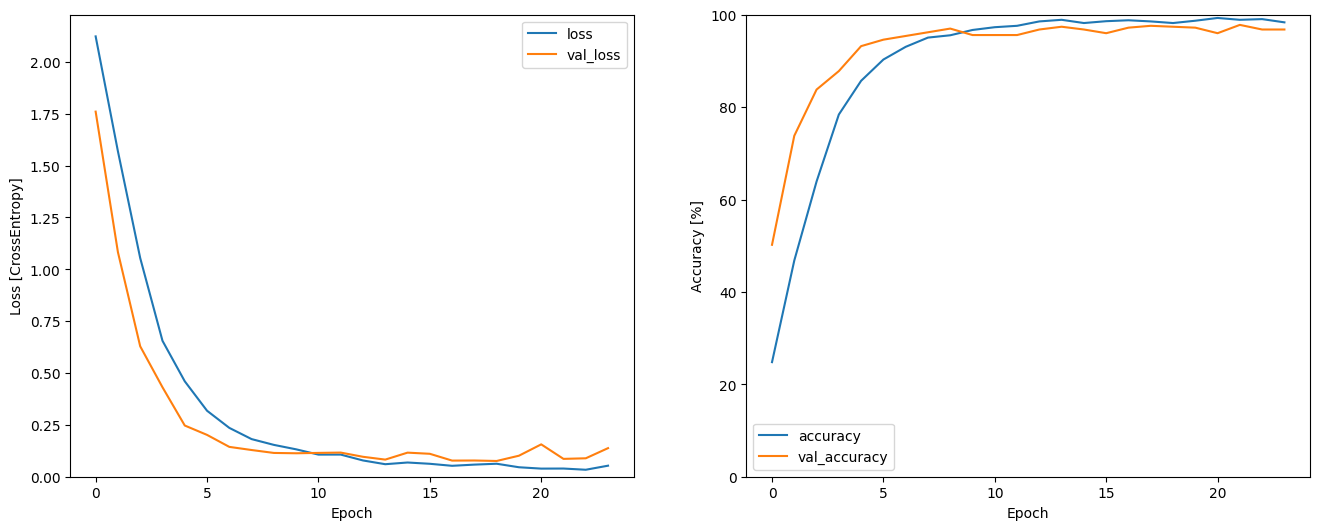

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

* Nuevamente el modelo funciona muy bien
*
Otra vez el overfitting es minio.

### 9.7. *Métricas*

#### 9.7.1. **Cálculo de predicciones de test**

In [ ]:
y_pred = model.predict(test_rnn_spectrogram_ds)

8/8 [==============================] - 0s 6ms/step


#### 9.7.2. **Matriz de confusión**

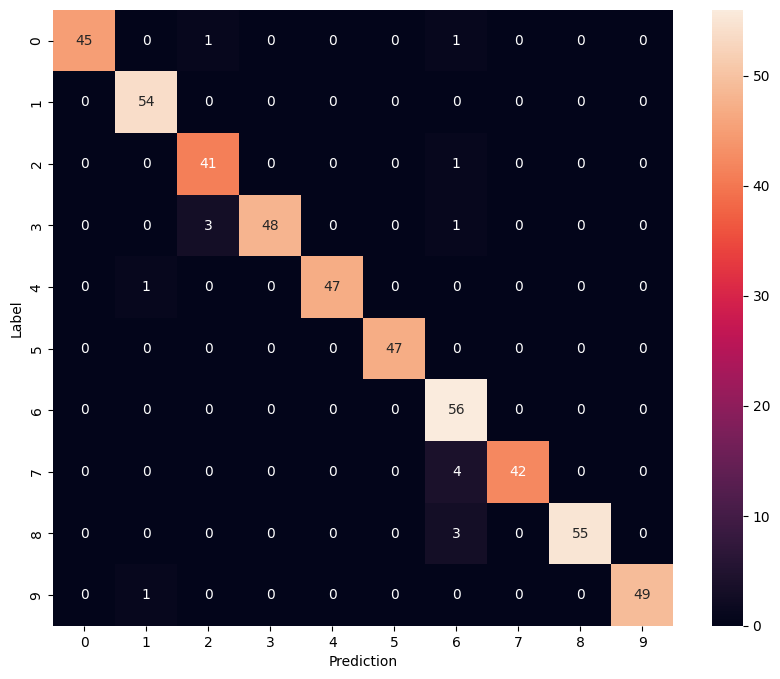

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_rnn_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=range(0,10),
            yticklabels=range(0,10),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#### 9.7.3. **Informe de clasificación**

In [ ]:
report = classification_report(y_true.numpy(), y_pred.numpy(), target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        47
           1       0.96      1.00      0.98        54
           2       0.91      0.98      0.94        42
           3       1.00      0.92      0.96        52
           4       1.00      0.98      0.99        48
           5       1.00      1.00      1.00        47
           6       0.85      1.00      0.92        56
           7       1.00      0.91      0.95        46
           8       1.00      0.95      0.97        58
           9       1.00      0.98      0.99        50

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## 10. **Conclusiones**

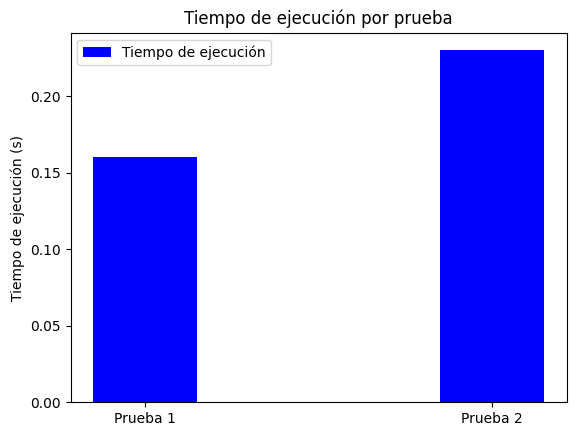

In [ ]:
# Tiempo de ejecución de cada prueba
time_test1, time_test2 = round(total_time_test1, 2), round(total_time_test2, 2)
tiempo = [time_test1, time_test2]

# Etiquetas para las pruebas
labels = ['Prueba 1', 'Prueba 2']

x = np.arange(len(labels))
width = 0.3

# Gráfico de barras
fig, ax = plt.subplots()

# Barras para el tiempo de ejecución
ax.bar(x, tiempo, width, label='Tiempo de ejecución', color='b')

# Etiquetas, título y leyenda
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Tiempo de ejecución por prueba')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Para ambos tipos de redes neuronales, tanto las **Redes Neuronales Recurrentes** *(RNN)* como las **Redes Neuronales Convolucionales** *(CNN)*, los resultados iniciales fueron notablemente positivos. En ambos casos, los modelos demostraron un desempeño excepcional desde el primer intento.

Aunque se observó un *overfitting* en ambos modelos, este fue mínimo. Esto indica que, aunque los modelos se ajustaron ligeramente mejor a los datos de entrenamiento en comparación con los datos de prueba, la diferencia en el rendimiento no fue significativa. En términos de exactitud y precisión, las matrices de confusión revelaron muy pocas equivocaciones en las pruebas realizadas, lo que resalta la eficacia de los modelos en clasificar correctamente los datos.

Aunque ambos modelos demostraron ser efectivos, para nosotros las **Redes Neuronales Recurrentes** proporcionaron resultados ligeramente mejores y mostraron una mayor robustez en el manejo del conjunto de datos, confirmando su idoneidad para la tarea en cuestión.